# e-commerce project
Проанализируйте совершенные покупки и ответить на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов) 


2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? (5 баллов)


3. По каждому товару определить, в какой день недели товар чаще всего покупается. (5 баллов)


4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов) 


5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти тут. (10 баллов)


6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. Описание подхода можно найти тут. (35 баллов)

Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться покупкой. Обосновать свой выбор ты можешь с помощью фактов оплат, статусов заказов и других имеющихся данных.

In [3]:
#Импортируем библиотеки
import pandas as pd
import datetime as dt
from datetime import datetime
import seaborn as sns

import matplotlib.pyplot as plt
import numpy as np

In [5]:
#Загружаем данные, переведя колонки с датами в тип дат
df_customers=pd.read_csv('https://raw.githubusercontent.com/IlonaInch/e_commerce_project/main/olist_customers_dataset.csv')
df_orders=pd.read_csv('https://raw.githubusercontent.com/IlonaInch/e_commerce_project/main/olist_orders_dataset.csv', parse_dates=['order_estimated_delivery_date','order_delivered_customer_date','order_delivered_carrier_date', 'order_approved_at', 'order_purchase_timestamp' ])
df_items=pd.read_csv('https://raw.githubusercontent.com/IlonaInch/e_commerce_project/main/olist_order_items_dataset.csv')

Посмотрим на каждую таблицу, а также их характеристики

In [6]:
#Информация о клиентах
df_customers.head(2)
#df_customers.shape
#df_customers.describe()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP


In [7]:
#Датасет с заказами клиентов (временные характеристики: во сколько сделан заказ/доставлен, статус заказа)
df_orders.head(2)
#df_orders.shape
#df_orders.dtypes
#df_orders.describe()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13


In [8]:
#Подробный датасет о наборе заказа (что заказал, цена товара)
df_items.head(2)
#df_items.shape
#df_items.describe()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93


In [9]:
# Для удобства, объединю все 3 таблицы по ключам таблицы Orders
df_merged = df_orders.merge(df_customers, on='customer_id').merge(df_items, on='order_id')
df_merged.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76


In [8]:
df_merged.shape

(112650, 18)

# 1
Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов)

In [9]:
# Посмотрим на статусы заказов. Я исключу "unavailable" из определения "покупки".
df_orders.order_status.value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

In [21]:
#Возьмем датасет с заказа, сгруппируем по уникальным пользователям, 
#посчитаем у каждого кол-во уникальных заказов, найдем нужное значение (тех, у кого был 1 заказ)

n_purchases=df_merged.loc[df_merged.order_status != "unavailable"]\
.groupby("customer_unique_id")\
.agg({'order_id':'nunique'})\
.rename(columns={'order_id': 'num_orders'})\
.sort_values('num_orders')\

In [22]:
n_purchases.query("num_orders == 1").shape

(92501, 1)

92501 число тех, у которых была одна покупка

# 2
Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)

In [65]:
#Из данных статуса заказа я есть 2 явные причины "отменен", "недоступен"
#Однако заказы могли также потерять во время отгрузки
#Поэтому я рассмотрю все статусы, кроме "доставлен", так как время ожидаемой доставки прошло

df_reasons = df_orders.loc[df_orders.order_status != 'delivered']\
            .groupby(['order_status', pd.Grouper(key="order_purchase_timestamp", freq="1M")])\
            .agg({'order_id':'nunique'})\
            .rename(columns={'order_id': 'num_orders'})
df_reasons

num_orders
order_status order_purchase_timestamp            
approved     2017-02-28                         1
             2017-04-30                         1
canceled     2016-09-30                         2
             2016-10-31                        24
             2017-01-31                         3
...                                           ...
unavailable  2018-04-30                         5
             2018-05-31                        16
             2018-06-30                         4
             2018-07-31                        18
             2018-08-31                         7

[113 rows x 1 columns]

In [71]:
#Посчитаем среднее по разным причинам
df_reasons.groupby('order_status').num_orders.mean().sort_values(ascending=False)

order_status
shipped        48.130435
unavailable    29.000000
canceled       26.041667
processing     15.842105
invoiced       14.952381
created         1.666667
approved        1.000000
Name: num_orders, dtype: float64

Видим, что самая частая причина - "Отправлен" со средним количество 48 заказов в месяц, далее "Недоступен" и "Отменен".

In [67]:
df_reasons =df_reasons.reset_index()
df_reasons['order_purchase_timestamp'] = df_reasons['order_purchase_timestamp'].dt.date

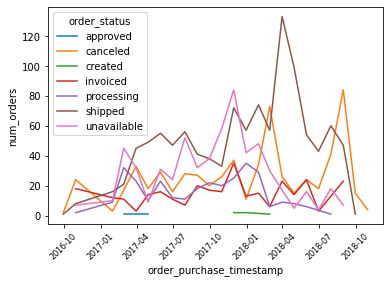

In [69]:
#Визуализируем, сколько заказов было недоставлено по разным причинам
sns.lineplot( x='order_purchase_timestamp',y='num_orders', data=df_reasons, hue='order_status')
plt.xticks(rotation=45, size=8)
plt.show()

# 3
По каждому товару определить, в какой день недели товар чаще всего покупается. (5 баллов)

In [17]:
#Дадим имена дням недели
df_merged['day_of_week'] = df_merged['order_purchase_timestamp'].dt.day_name()
df_merged.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,day_of_week
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,Monday
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,Tuesday


In [18]:
#Посмотрим на товары в заказах (исключая "Недоступные")
#Видим, что один и тот же товар покупается в разные дни недели,например, product_id = "aca2eb7d00ea1a7b8ebd4e68314663af", 
#Нам же нужно только максимальное значение
df_popular_products=df_merged.loc[df_merged.order_status != "unavailable"]\
                    .groupby(['product_id','day_of_week'])\
                    .agg({'order_item_id':'count'})\
                    .rename(columns={'order_item_id':'num_items'})\
                    .sort_values('num_items')\
                    .reset_index()\

df_popular_products.shape

(61224, 3)

In [20]:
#Возьмем максимальное кол-во в разбивке по товарам
max_df=df_popular_products\
                .groupby('product_id', as_index=False)\
                .agg({'num_items':'max'})\
                .sort_values(['num_items'], ascending=False)

In [21]:
#Соединим датасеты. Те значения, у которых кол-во = 1 дублируются. 
#Например, product_id =c24d97e07dcb8f32a8bfbe755731950a был куплен один раз как в понедельник, так и субботу
df_popular_products.merge(max_df,how='inner', on=['product_id', 'num_items']).sort_values('num_items', ascending=False)\
                    .drop_duplicates('product_id')

,product_id,day_of_week,num_items
42698,422879e10f46682990de24d770e7f83d,Wednesday,93
42697,99a4788cb24856965c36a24e339b6058,Monday,92
42696,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
42695,53b36df67ebb7c41585e8d54d6772e08,Tuesday,76
42694,368c6c730842d78016ad823897a372db,Friday,67
...,...,...,...
14231,c22dc992a198753e51e4a25f83957b9b,Monday,1
14232,c22eb1f87996d0da0b60271a9806cd59,Monday,1
14235,c24e49a2c52e4cd8067f8753b955e407,Monday,1
14237,c24f29c580f6317c48c8fa0661a232e9,Monday,1


# 4
Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов)

In [166]:
#Добавим колонки "месяц" и "год"
df_merged['month']=df_merged['order_purchase_timestamp'].dt.month_name()
df_merged['year']=df_merged['order_purchase_timestamp'].dt.year

In [20]:
#Выведем, сколько дней содержится в каждом месяце
df_merged['days_in_month']=df_merged['order_purchase_timestamp'].apply(lambda t: pd.Period(t, freq='S').days_in_month)

In [21]:
#Поделим количество дней на 7 (т.к. 7 дней в неделе)
df_merged['weeks_in_month']=df_merged['days_in_month']/7

In [23]:
#Сгруппируем уникальных пользователей, с'агрегируем кол-во их уникальных заказов
orders_weekly = df_merged.groupby(['year','customer_unique_id', 'month','weeks_in_month'], as_index=False)\
.agg({'order_id':'nunique'}).rename(columns={'order_id':'num_orders'}).sort_values('num_orders', ascending=False)

In [58]:
#Наконец, высчитаем, сколько в среднем приходится заказов на пользователя.
#Для этого разделим кол-во заказов каждого пользователя на кол-во недель в месяце. 
# Самое большее значение пришлось на пользователя customer_unique_id = 12f5d6e1cbf93dafd9dcc19095df0b3d, 
#у него было 6 заказов, поэтому его средний показатель был больше 1 в неделю 
orders_weekly['orders_per_week']=orders_weekly.num_orders/orders_weekly.weeks_in_month.mean()
orders_weekly.head(2)

,year,customer_unique_id,month,weeks_in_month,num_orders,orders_per_week
3599,2017,12f5d6e1cbf93dafd9dcc19095df0b3d,January,4.428571,6,1.379887
6765,2017,25a560b9a6006157838aab1bdbd68624,April,4.285714,4,0.919924


# 5 
Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти тут. (10 баллов)

In [73]:
#Убедимся, что время заказа прееведено в тип даты
df_new=df_merged.assign(date = lambda x: pd.to_datetime(x.order_purchase_timestamp))\
    .loc[:, ['customer_unique_id', 'date']]
df_new.head(2)

,customer_unique_id,date
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33
1,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37


In [74]:
#Изменим отображение данных на год-месяц, уберем дубликаты id покупателей
user_cohort = (df_new[['customer_unique_id', 'date']]
                 .assign(cohort = lambda x: x.date.dt.to_period('M'))
                 .sort_values('date')
                 .drop_duplicates('customer_unique_id')
                 .reset_index()
                 .loc[:, ['customer_unique_id', 'cohort']]
                )
user_cohort.head(5)

,customer_unique_id,cohort
0,b7d76e111c89f7ebf14761390f0f7d17,2016-09
1,4854e9b3feff728c13ee5fc7d1547e92,2016-09
2,830d5b7aaa3b6f1e9ad63703bec97d23,2016-09
3,0eb1ee9dba87f5b36b4613a65074337c,2016-10
4,32ea3bdedab835c3aa6cb68ce66565ef,2016-10


In [84]:
# Посчитаем дельту, как разница между датой покупки и когортой 
from operator import attrgetter

cohort_df = (
  pd.merge(df_new, user_cohort, on='customer_unique_id')
  .assign(date_of_purchase = lambda x: x.date.dt.to_period('M'),
          delta = lambda x: (x.date_of_purchase - x.cohort).apply(attrgetter('n')))
  .loc[:, ['customer_unique_id', 'date', 'cohort', 'date_of_purchase', 'delta']]
  )
cohort_df.head(2)#.sort_values('delta')

,customer_unique_id,date,cohort,date_of_purchase,delta
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,2017-09,2017-10,1
1,7c396fd4830fd04220f754e42b4e5bff,2017-09-04 11:26:38,2017-09,2017-09,0


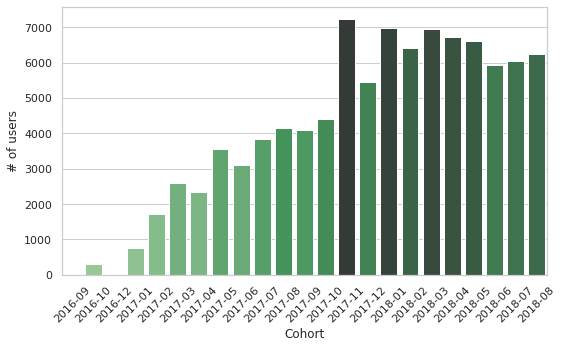

In [76]:
#Для начала визуализируем размер каждой когорты
import numpy as np
size_cohorts = (cohort_df
                .groupby(['cohort', 'delta'])[['customer_unique_id']]
                .nunique()
                .query('delta == 0')
                .reset_index()
                )

# Plot:
sns.set(style="whitegrid", color_codes=True)
pal = sns.color_palette("Greens_d", len(size_cohorts))
rank = size_cohorts.customer_unique_id.argsort().argsort()   
plt.figure(figsize=(8, 5))
ax = sns.barplot(
  data=size_cohorts, 
  y='customer_unique_id', 
  x='cohort', 
  palette=np.array(pal)[rank]
  )
ax.set(xlabel='Cohort', ylabel='# of users')
## [Text(0.5, 0, 'Cohort'), Text(0, 0.5, '# of sellers')]
plt.xticks(rotation=45);
plt.tight_layout();
plt.show()

In [85]:
#Далее посчитаем количество уникальных пользователей по когортам;
#Посчитаем общее количество пользователей в каждой когорте в первый месяц, когда дельта = 0
#Посчитаем пропорцию пользователей от общего количества
#Так как нам нужен определенный timestamp, подходит только 2017 год
cohort_df = (cohort_df
             .query('cohort > "2016-12" & cohort < "2018-01"')
             .groupby(['cohort', 'delta'])[['customer_unique_id']]
             .nunique()
             .assign(total = lambda x: x.groupby('cohort')[['customer_unique_id']]
                                       .transform(lambda x: x[0]),
                     proportion = lambda x: 100 * x.customer_unique_id / x.total)
             .reset_index()
             .loc[:, ['cohort', 'delta', 'proportion']]
            )
cohort_df.head(2)

,cohort,delta,proportion
0,2017-01,0,100.000000
1,2017-01,1,0.397878


In [78]:
#Сделаем сводную таблицу
cohort_pivot = (
  cohort_df[['cohort', 'delta', 'proportion']]
  .pivot(columns='delta', index='cohort')['proportion']
  )
cohort_pivot

delta,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19
cohort,,,,,,,,,,,,,,,,,,,
2017-01,100.0,0.397878,0.265252,0.132626,0.397878,0.132626,0.397878,0.132626,0.132626,NaN,0.397878,0.132626,0.663130,0.397878,0.132626,0.132626,0.265252,0.397878,0.132626
2017-02,100.0,0.234604,0.293255,0.117302,0.410557,0.117302,0.234604,0.175953,0.117302,0.175953,0.117302,0.293255,0.117302,0.175953,0.117302,0.058651,0.058651,0.234604,NaN
2017-03,100.0,0.500963,0.346821,0.385356,0.346821,0.154143,0.154143,0.308285,0.346821,0.077071,0.385356,0.115607,0.231214,0.115607,0.154143,0.231214,0.077071,0.154143,NaN
2017-04,100.0,0.598546,0.213767,0.171013,0.342027,0.256520,0.342027,0.299273,0.299273,0.171013,0.256520,0.085507,0.085507,0.042753,0.085507,0.085507,0.171013,NaN,NaN
2017-05,100.0,0.477528,0.477528,0.393258,0.308989,0.337079,0.421348,0.140449,0.252809,0.280899,0.252809,0.337079,0.252809,0.028090,0.196629,0.252809,NaN,NaN,NaN
2017-06,100.0,0.481696,0.353243,0.385356,0.256904,0.385356,0.385356,0.224791,0.128452,0.224791,0.321130,0.353243,0.160565,0.128452,0.192678,NaN,NaN,NaN,NaN
2017-07,100.0,0.520427,0.364299,0.234192,0.286235,0.208171,0.312256,0.104085,0.182149,0.260213,0.208171,0.286235,0.130107,0.260213,NaN,NaN,NaN,NaN,NaN
2017-08,100.0,0.674861,0.337431,0.265124,0.361533,0.530248,0.289226,0.265124,0.144613,0.144613,0.241022,0.192818,0.096409,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,100.0,0.684597,0.537897,0.293399,0.440098,0.220049,0.220049,0.244499,0.293399,0.171149,0.268949,0.073350,NaN,NaN,NaN,NaN,NaN,NaN,NaN


В задании требовалось выявить когорту с самым высоким retention на 3й месяц.

Это когорта "2017-05" со значением Retention Rate =  0.393258

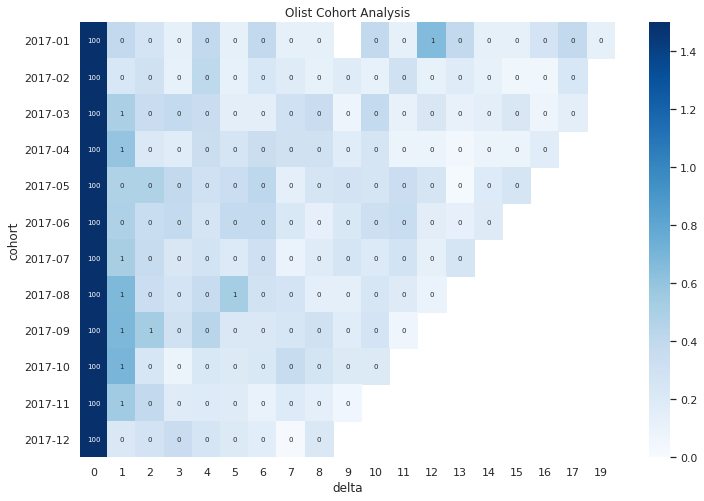

In [104]:
#Посмотрим на карту и увидим, что retention rate везде очень низкий, я немного выделю значения с помощью установления интервала для шкалы
plt.figure(figsize=(12, 8))
sns.heatmap(
  cohort_pivot, vmin=0, vmax=1.5,
  annot=True,
    cmap='Blues', 
  annot_kws={"fontsize":7},
  fmt='.0f'
  ).set_title("Olist Cohort Analysis")


plt.show()


# 6. RFM - анализ
Часто для качественного анализа аудитории используют подходы, основанные на сегментации. 

Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. 

В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. 

Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. 

Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. Описание подхода можно найти тут. (35 баллов)

In [10]:
#Так как данные датасета исторические (с 2016 по 2018 год), брать 2022год кажется неверным. 
#Видим, что разница от момента заказа до сегодняшнего дня колеблется от 1409 до 2165 дней.

df_merged['nDays_lastPurchase_fromToday'] = datetime.today() - df_merged.order_purchase_timestamp
df_merged.nDays_lastPurchase_fromToday.sort_values(ascending=False)

5086    2165 days 18:03:23.785627
5085    2165 days 18:03:23.785627
4925    2165 days 15:03:08.785627
34804   2155 days 03:02:04.785627
34803   2155 days 03:02:04.785627
                   ...           
34061   1442 days 01:00:19.785627
35685   1442 days 01:00:14.785627
78871   1442 days 00:26:42.785627
99673   1442 days 00:18:05.785627
70511   1437 days 06:11:45.785627
Name: nDays_lastPurchase_fromToday, Length: 112650, dtype: timedelta64[ns]

In [11]:
#Я возьму дату '2018-10-01' как "текущую", представив, что нас интересует то время.
df_merged.order_purchase_timestamp.max()

Timestamp('2018-09-03 09:06:57')

In [12]:
#Recency from 2018-10-01
df_merged['nDays_lastPurchase_from2019'] = (pd.to_datetime('2018-10-01')-(df_merged.order_purchase_timestamp)).dt.days
r = df_merged.query('order_status != "canceled"')\
.groupby(['customer_unique_id','order_purchase_timestamp'])\
.agg({'nDays_lastPurchase_from2019':'min'})\
.sort_values('nDays_lastPurchase_from2019', ascending=False)


In [13]:
#Frequency
f = df_merged\
.query('order_status != "canceled"')\
.groupby('customer_unique_id')\
.agg({'order_id':'nunique'})\
.rename(columns={'order_id':'num_orders'})


In [14]:
#Monetary
m = df_merged\
.query('order_status != "canceled"')\
.groupby(['customer_unique_id', 'order_id'])\
.agg({'price':'sum'})\
.rename(columns={'price':'revenue'})


In [15]:
#Замерджим 
rfm=r.merge(f, on='customer_unique_id').merge(m, on='customer_unique_id')

In [16]:
# посмотрим на границы классов
quantiles = rfm.quantile(q=[0.25, 0.5, 0.75])
quantiles

,nDays_lastPurchase_from2019,num_orders,revenue
0.25,150.0,1.0,45.9
0.50,256.0,1.0,85.9
0.75,384.0,1.0,149.9


In [17]:
#Определим квантили, исходя из дней после последней оплаты
rfm["RecencyScore"] = pd.cut(rfm["nDays_lastPurchase_from2019"], 
                                       bins=[-1, 
                                         np.percentile(rfm["nDays_lastPurchase_from2019"], 25), 
                                             np.percentile(rfm["nDays_lastPurchase_from2019"], 50), 
                                             np.percentile(rfm["nDays_lastPurchase_from2019"], 75), 
                                             rfm["revenue"].max()], 
                                       labels=[4, 3, 2, 1]).astype("int")

In [18]:
#Построим функцию сегментации по классу частоты покупок
def FClass(value, parameter_name,quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 1
    elif value <= quantiles_table[parameter_name][0.50]:
        return 2
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 3
    else:
        return 4
#Присвоим класс показателю
rfm['FrequencyScore'] = rfm['num_orders'].apply(FClass, args=('num_orders',quantiles))

In [19]:
#Определим квантиль для класса выручки
rfm["MonetaryScore"] = pd.cut(rfm["revenue"], 
                                       bins=[-1, 
                                         np.percentile(rfm["revenue"], 25), 
                                             np.percentile(rfm["revenue"], 50), 
                                             np.percentile(rfm["revenue"], 75), 
                                             rfm["revenue"].max()], 
                                       labels=[1, 2, 3, 4]).astype("int")

In [20]:
#Соединим в одну строку полученные значения R, F, M
rfm['RFM'] = rfm['RecencyScore'].astype(str) + rfm['FrequencyScore'].astype(str) +rfm['MonetaryScore'].astype(str)

In [22]:
#Отсортируем, где "444" - наиболее лояльные пользователи, а сегмент "111" - наименее
rfm = rfm.reset_index().sort_values(['RFM','revenue'], ascending=[False, False])
rfm.drop_duplicates()

,index,customer_unique_id,nDays_lastPurchase_from2019,num_orders,revenue,RecencyScore,FrequencyScore,MonetaryScore,RFM
0,84755,7b0eaf68a16e4808e5388c67345033c9,134,2,1849.00,4,4,4,444
1,84757,7b0eaf68a16e4808e5388c67345033c9,134,2,1849.00,4,4,4,444
2,93456,906a8a4ec9f3d4c3e64fa6d1c4fe6009,87,2,1800.00,4,4,4,444
3,93458,906a8a4ec9f3d4c3e64fa6d1c4fe6009,72,2,1800.00,4,4,4,444
4,94556,525cda9909aa001ebed396f6e55eae01,79,2,1514.30,4,4,4,444
...,...,...,...,...,...,...,...,...,...
105136,26515,4cca4cf79eeddc8d36b6b659fbce5cff,395,1,3.99,1,1,1,111
105137,958,4079d39cb3fdea47201540107c1673dc,612,1,3.90,1,1,1,111
105138,16229,5a1b7cd1a94f3483b6415f8609db83dc,465,1,3.90,1,1,1,111
105139,21484,2bca5fe01d46ab5cc2bc5aaade88d850,427,1,3.90,1,1,1,111


In [59]:
#Посмотрим, сколько пользователей в каждом сегменте
rfm.RFM.value_counts(ascending=False)

142    6116
242    6050
141    5964
144    5960
244    5886
143    5867
343    5822
241    5743
444    5730
341    5722
342    5717
441    5577
443    5527
243    5504
442    5464
344    5453
414    1183
413     977
412     908
313     901
314     879
411     842
212     841
213     835
312     811
311     805
214     775
211     742
114     678
112     625
113     622
111     615
Name: RFM, dtype: int64